# DEIMOS Optical Model

I transcribed the IDL optical model for DEIMOS into python.  Here's an example of how it works:

In [1]:
import os
import numpy

from matplotlib import pyplot

from pypeit.spectrographs.keck_deimos import KeckDEIMOSSpectrograph

First instantiate the spectrograph:

In [2]:
spec = KeckDEIMOSSpectrograph()

Then we'll use it to read the slits from a file and propagate them through to the image plane of the detector in both the image coordinates (`*img`) and the CCD coordinates (`*pix`).  You need the dev suite to run this:

In [3]:
f = os.path.join(os.environ['PYPEIT_DEV'],
                 'RAW_DATA/Keck_DEIMOS/830G_M/DE.20100913.22358.fits.gz')

x_img, y_img, ccd, x_pix, y_pix = spec.mask_to_pixel_coordinates(filename=f)

There are a number of things going on underneath the hood here.  The function:
 - reads the slit mask from the `BluSlits` extension
 - instantiates a `pypeit.spectrographs.opticalmodel.RefectionGrating` object based on the file header
 - instantiates a `pypeit.spectrographs.keck_deimos.DEIMOSOpticalModel` object the does the ray tracing
 - instantiates a `pypeit.spectrographs.keck_deimos.DEIMOSDetectorMap` object that converts the image plane coordinates in mm to the pixel coordinates on the relevant detector.
 
Run in this way, the method propagates the center of all slits at the central wavelength pulled from the file through to the detector.

We can then use the results to figure out how many slits were on each detector.  Slits with a ccd of -1 means that their center didn't land on any detector.  There are five of these for this example file.

In [4]:
ccds_with_slits_at_cwl, n_per_ccd = numpy.unique(ccd, return_counts=True)
print(ccds_with_slits_at_cwl)
print(n_per_ccd)

[-1  1  2  3  4  5  6  7  8]
[ 5 11 15 13 14 15 10 12 11]


The instantiated objects are kept within the `KeckDEIMOSSpectograph` instance so you can access them later.  For example, we can use the `DetectorMap` instance to plot the detectors in the image plane.

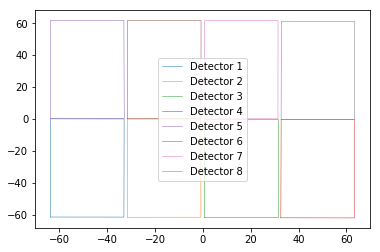

In [5]:
n = numpy.repeat(numpy.arange(spec.detector_map.nccd), 5).reshape(spec.detector_map.nccd,5)+1
cx = numpy.array([0, spec.detector_map.npix[0], spec.detector_map.npix[0], 0, 0]
                    *spec.detector_map.nccd).reshape(spec.detector_map.nccd,5)
cy = numpy.array([0, 0, spec.detector_map.npix[1], spec.detector_map.npix[1], 0]
                    *spec.detector_map.nccd).reshape(spec.detector_map.nccd,5)

det_x_img, det_y_img = spec.detector_map.image_coordinates(cx, cy, n)

for i, (x,y) in enumerate(zip(det_x_img, det_y_img)):
    pyplot.plot(x,y, label='Detector {0}'.format(i+1), lw=0.5)
pyplot.legend()
pyplot.show()

I can also plot the slit mask positions, both the centers and draw an outline of each slit based on the slit corners:

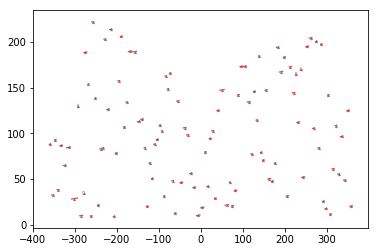

In [6]:
for c in spec.slitmask.corners:
    pyplot.plot(c[:,0], c[:,1], color='C3', lw=0.5)
pyplot.scatter(spec.slitmask.center[:,0], spec.slitmask.center[:,1],
               marker='^', s=10, lw=0, color='0.5')
pyplot.show()

I can calculate more coordinate positions using the established internals (without having to reread the file) by just calling the method again with a specific set of x and y coordinates.  Here I'll calculate the coordinates for all the slit corners, replot the detector map, and overplot the slits:

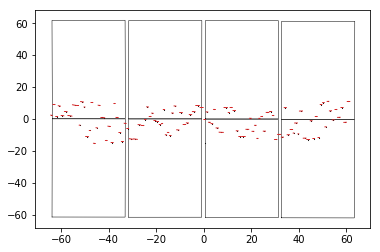

In [7]:
xc_img, yc_img, c_ccd, xc_pix, yc_pix \
    = spec.mask_to_pixel_coordinates(x=spec.slitmask.corners[...,0].ravel(),
                                     y=spec.slitmask.corners[...,1].ravel())
    
xc_img = xc_img.reshape(spec.slitmask.corners.shape[:2])
yc_img = yc_img.reshape(spec.slitmask.corners.shape[:2])

# Detector map
for x,y in zip(det_x_img, det_y_img):
    pyplot.plot(x,y, lw=0.5, color='k')
# Slit corners
for x,y in zip(xc_img, yc_img):
    pyplot.plot(x, y, color='C3', lw=0.5)
# Slit centers
pyplot.scatter(x_img, y_img, color='k', marker='.', s=5, lw=0)
pyplot.show()


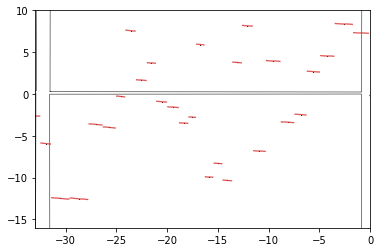

In [8]:
#Zoom in
# Detector map
for x,y in zip(det_x_img, det_y_img):
    pyplot.plot(x,y, lw=0.5, color='k')
# Slit corners
for x,y in zip(xc_img, yc_img):
    pyplot.plot(x, y, color='C3', lw=0.5)
# Slit centers
pyplot.scatter(x_img, y_img, color='k', marker='.', s=5, lw=0)
pyplot.xlim([-33,0])
pyplot.ylim([-16,10])
pyplot.show()